In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 

X = pd.read_parquet("../artifacts/features.parquet")
metadata = pd.read_parquet("../artifacts/metadata.parquet")

print(f"X shape: {X.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)


X shape: (50878, 36)


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.0
  Silhouette: 0.241, DB: 1.162


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.57044514e-12 9.35205549e-07 6.25761130e-07 5.40802456e-08
 5.82667755e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 24 instead with accuracy 
4.395432500282267e-07.

  _, diffusion_map = lobpcg(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.84637985e-14 9.35206026e-07 6.25760424e-07 5.40802348e-08
 5.82667748e-07]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


n_neighbors=30, min_dist=0.1
  Silhouette: 0.258, DB: 1.085


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.25
  Silhouette: 0.290, DB: 1.036


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.5
  Silhouette: 0.318, DB: 1.033


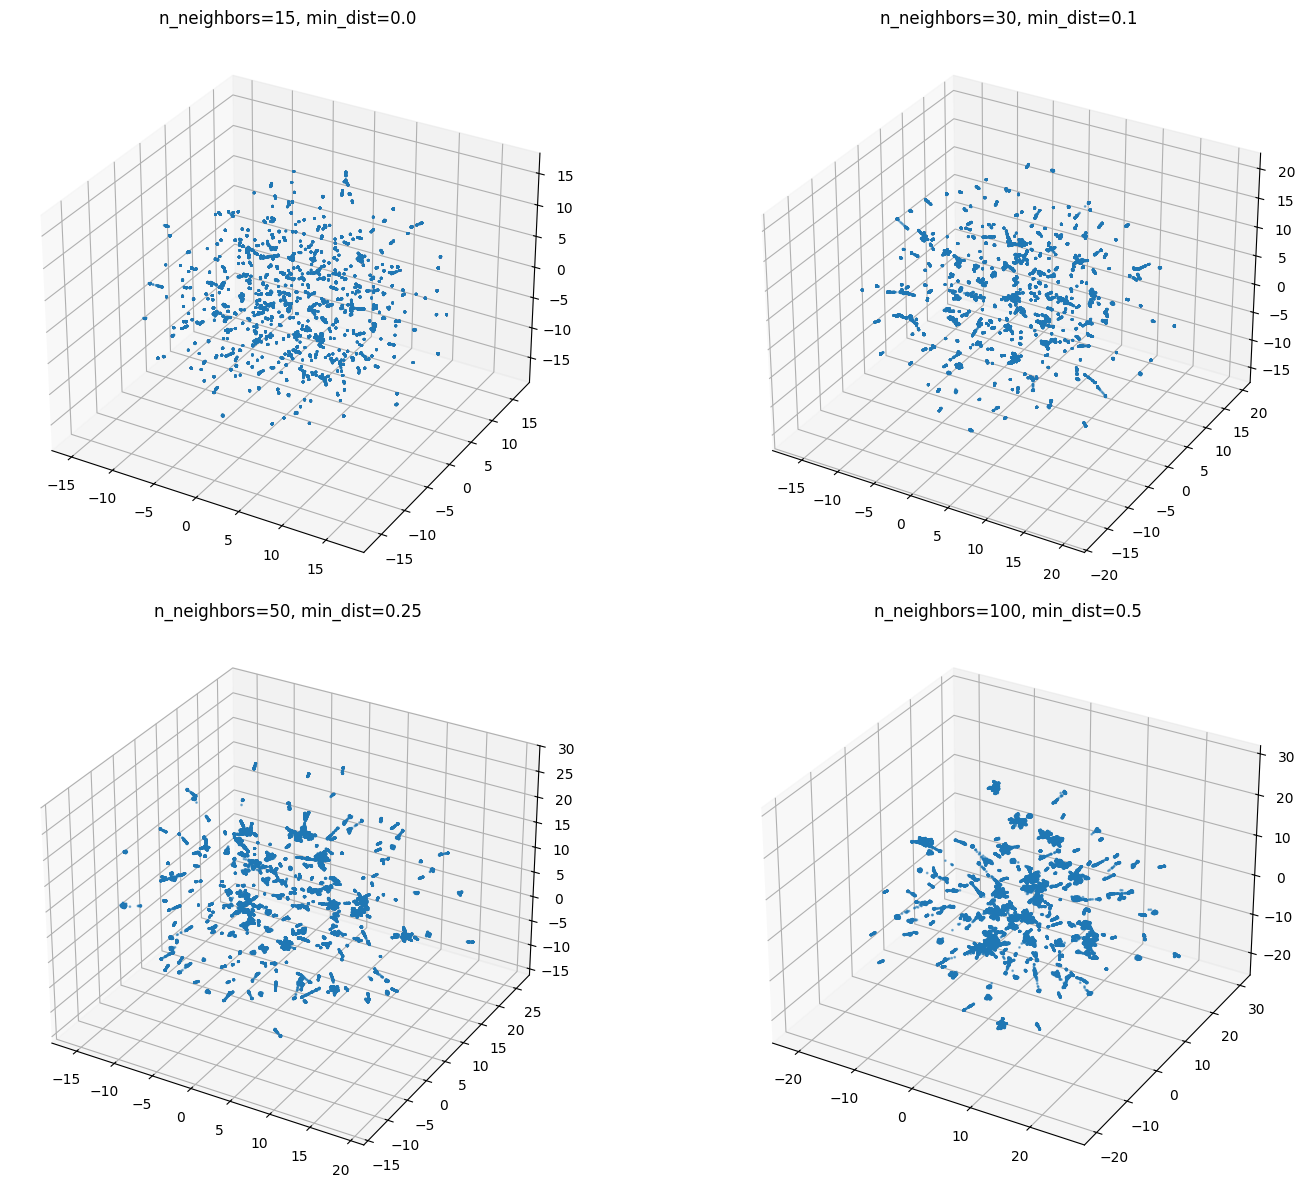

In [5]:
# lets try some different hyperparameters for UMAP and see which ones look the best

# few different combos for hyperparameters 
configs = [
    {'n_neighbors': 15, 'min_dist': 0.0},
    {'n_neighbors': 30, 'min_dist': 0.1},
    {'n_neighbors': 50, 'min_dist': 0.25},
    {'n_neighbors': 100, 'min_dist': 0.5},
]

results=[]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

fig = plt.figure(figsize=(16, 12))

for i, config in enumerate(configs, 1):
    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=config['n_neighbors'],
        min_dist=config['min_dist'],
        random_state=42
    )
    
    embedding = reducer.fit_transform(X_pca)

    kmeans = KMeans(n_clusters = 10, random_state=42)
    labels = kmeans.fit_predict(embedding)

    # Calculate metrics
    silhouette = silhouette_score(embedding, labels)
    db_score = davies_bouldin_score(embedding, labels)

    results.append((silhouette, db_score))

    print(f"n_neighbors={config['n_neighbors']}, min_dist={config['min_dist']}")
    print(f"  Silhouette: {silhouette:.3f}, DB: {db_score:.3f}")
    
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], 
               s=1, alpha=0.5)
    ax.set_title(f"n_neighbors={config['n_neighbors']}, min_dist={config['min_dist']}")

plt.tight_layout()
plt.show()



In [6]:

# testing more params using metrics 
param_grid = {
    'n_neighbors': [15, 30, 50, 100, 200],
    'min_dist': [0.0, 0.1, 0.25, 0.5, 0.75],
    'metric': ['euclidean', 'cosine', 'correlation']
}

results = []

for n_neighbors in param_grid['n_neighbors']:
    for min_dist in param_grid['min_dist']:
        for metric in param_grid['metric']:
            
            # Fit UMAP
            reducer = umap.UMAP(
                n_components=3,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                metric=metric,
                random_state=42
            )
            
            embedding = reducer.fit_transform(X_pca)
            
            # Evaluate with clustering metrics
            # (You need to cluster first - use quick K-means)
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=10, random_state=42)
            labels = kmeans.fit_predict(embedding)
            
            # Calculate metrics
            silhouette = silhouette_score(embedding, labels)
            db_score = davies_bouldin_score(embedding, labels)
            
            results.append({
                'n_neighbors': n_neighbors,
                'min_dist': min_dist,
                'metric': metric,
                'silhouette': silhouette,
                'davies_bouldin': db_score
            })
            
            print(f"n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}")
            print(f"  Silhouette: {silhouette:.3f}, DB: {db_score:.3f}")

# Convert to DataFrame and find best
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('silhouette', ascending=False)

print("\nTop 5 configurations:")
print(results_df.head())

# Best params
best = results_df.iloc[0]
print(f"\nBest params: n_neighbors={best['n_neighbors']}, min_dist={best['min_dist']}, metric={best['metric']}")


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.0, metric=euclidean
  Silhouette: 0.241, DB: 1.162


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.0, metric=cosine
  Silhouette: 0.261, DB: 1.112


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.0, metric=correlation
  Silhouette: 0.261, DB: 1.093


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.1, metric=euclidean
  Silhouette: 0.250, DB: 1.106


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.1, metric=cosine
  Silhouette: 0.253, DB: 1.072


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.1, metric=correlation
  Silhouette: 0.256, DB: 1.084


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.25, metric=euclidean
  Silhouette: 0.234, DB: 1.129


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.25, metric=cosine
  Silhouette: 0.256, DB: 1.091


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.25, metric=correlation
  Silhouette: 0.250, DB: 1.070


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.5, metric=euclidean
  Silhouette: 0.234, DB: 1.145


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.5, metric=cosine
  Silhouette: 0.251, DB: 1.083


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.5, metric=correlation
  Silhouette: 0.239, DB: 1.123


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.75, metric=euclidean
  Silhouette: 0.240, DB: 1.104


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.75, metric=cosine
  Silhouette: 0.242, DB: 1.106


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.75, metric=correlation
  Silhouette: 0.243, DB: 1.086


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.57044514e-12 9.35205549e-07 6.25761130e-07 5.40802456e-08
 5.82667755e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 24 instead with accuracy 
4.395432500282267e-07.

  _, diffusion_map = lobpcg(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.84637985e-14 9.35206026e-07 6.25760424e-07 5.40802348e-08
 5.82667748e-07]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


n_neighbors=30, min_dist=0.0, metric=euclidean
  Silhouette: 0.253, DB: 1.049


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.0, metric=cosine
  Silhouette: 0.258, DB: 1.087


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.0, metric=correlation
  Silhouette: 0.269, DB: 1.059


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.57044514e-12 9.35205549e-07 6.25761130e-07 5.40802456e-08
 5.82667755e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 24 instead with accuracy 
4.395432500282267e-07.

  _, diffusion_map = lobpcg(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.84637985e-14 9.35206026e-07 6.25760424e-07 5.40802348e-08
 5.82667748e-07]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


n_neighbors=30, min_dist=0.1, metric=euclidean
  Silhouette: 0.258, DB: 1.085


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.1, metric=cosine
  Silhouette: 0.259, DB: 1.107


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.1, metric=correlation
  Silhouette: 0.263, DB: 1.040


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.57044514e-12 9.35205549e-07 6.25761130e-07 5.40802456e-08
 5.82667755e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 24 instead with accuracy 
4.395432500282267e-07.

  _, diffusion_map = lobpcg(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.84637985e-14 9.35206026e-07 6.25760424e-07 5.40802348e-08
 5.82667748e-07]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


n_neighbors=30, min_dist=0.25, metric=euclidean
  Silhouette: 0.249, DB: 1.171


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.25, metric=cosine
  Silhouette: 0.257, DB: 1.100


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.25, metric=correlation
  Silhouette: 0.267, DB: 1.076


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.57044514e-12 9.35205549e-07 6.25761130e-07 5.40802456e-08
 5.82667755e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 24 instead with accuracy 
4.395432500282267e-07.

  _, diffusion_map = lobpcg(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.84637985e-14 9.35206026e-07 6.25760424e-07 5.40802348e-08
 5.82667748e-07]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


n_neighbors=30, min_dist=0.5, metric=euclidean
  Silhouette: 0.254, DB: 1.048


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.5, metric=cosine
  Silhouette: 0.254, DB: 1.096


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.5, metric=correlation
  Silhouette: 0.249, DB: 1.100


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.57044514e-12 9.35205549e-07 6.25761130e-07 5.40802456e-08
 5.82667755e-07]
not reaching the requested tolerance 7.450580596923828e-07.
Use iteration 24 instead with accuracy 
4.395432500282267e-07.

  _, diffusion_map = lobpcg(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.84637985e-14 9.35206026e-07 6.25760424e-07 5.40802348e-08
 5.82667748e-07]
not reaching the requested tolerance 7.450580596923828e-07.
  _, diffusion_map = lobpcg(


n_neighbors=30, min_dist=0.75, metric=euclidean
  Silhouette: 0.242, DB: 1.108


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.75, metric=cosine
  Silhouette: 0.247, DB: 1.084


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=30, min_dist=0.75, metric=correlation
  Silhouette: 0.255, DB: 1.069


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.0, metric=euclidean
  Silhouette: 0.234, DB: 1.293


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.0, metric=cosine
  Silhouette: 0.260, DB: 1.142


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.0, metric=correlation
  Silhouette: 0.270, DB: 1.097


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.1, metric=euclidean
  Silhouette: 0.271, DB: 1.149


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.1, metric=cosine
  Silhouette: 0.261, DB: 1.106


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.1, metric=correlation
  Silhouette: 0.260, DB: 1.152


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.25, metric=euclidean
  Silhouette: 0.290, DB: 1.036


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.25, metric=cosine
  Silhouette: 0.256, DB: 1.072


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.25, metric=correlation
  Silhouette: 0.252, DB: 1.156


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.5, metric=euclidean
  Silhouette: 0.282, DB: 0.993


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.5, metric=cosine
  Silhouette: 0.248, DB: 1.113


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.5, metric=correlation
  Silhouette: 0.257, DB: 1.093


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.75, metric=euclidean
  Silhouette: 0.263, DB: 1.125


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.75, metric=cosine
  Silhouette: 0.261, DB: 1.051


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50, min_dist=0.75, metric=correlation
  Silhouette: 0.261, DB: 1.064


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.0, metric=euclidean
  Silhouette: 0.298, DB: 1.105


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.0, metric=cosine
  Silhouette: 0.270, DB: 1.157


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.0, metric=correlation
  Silhouette: 0.262, DB: 1.097


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.1, metric=euclidean
  Silhouette: 0.290, DB: 1.081


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.1, metric=cosine
  Silhouette: 0.280, DB: 1.068


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.1, metric=correlation
  Silhouette: 0.259, DB: 1.138


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.25, metric=euclidean
  Silhouette: 0.313, DB: 1.053


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.25, metric=cosine
  Silhouette: 0.270, DB: 1.091


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.25, metric=correlation
  Silhouette: 0.265, DB: 1.128


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.5, metric=euclidean
  Silhouette: 0.318, DB: 1.033


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.5, metric=cosine
  Silhouette: 0.273, DB: 1.076


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.5, metric=correlation
  Silhouette: 0.254, DB: 1.118


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.75, metric=euclidean
  Silhouette: 0.303, DB: 1.051


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.75, metric=cosine
  Silhouette: 0.270, DB: 1.089


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100, min_dist=0.75, metric=correlation
  Silhouette: 0.254, DB: 1.123


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.0, metric=euclidean
  Silhouette: 0.317, DB: 1.080


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.0, metric=cosine
  Silhouette: 0.278, DB: 1.066


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.0, metric=correlation
  Silhouette: 0.289, DB: 1.039


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.1, metric=euclidean
  Silhouette: 0.334, DB: 1.016


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.1, metric=cosine
  Silhouette: 0.288, DB: 1.063


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.1, metric=correlation
  Silhouette: 0.283, DB: 1.057


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.25, metric=euclidean
  Silhouette: 0.308, DB: 1.022


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.25, metric=cosine
  Silhouette: 0.262, DB: 1.089


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.25, metric=correlation
  Silhouette: 0.273, DB: 1.121


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.5, metric=euclidean
  Silhouette: 0.317, DB: 1.116


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.5, metric=cosine
  Silhouette: 0.271, DB: 1.101


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.5, metric=correlation
  Silhouette: 0.254, DB: 1.084


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.75, metric=euclidean
  Silhouette: 0.314, DB: 1.010


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.75, metric=cosine
  Silhouette: 0.273, DB: 1.054


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=200, min_dist=0.75, metric=correlation
  Silhouette: 0.260, DB: 1.098

Top 5 configurations:
    n_neighbors  min_dist     metric  silhouette  davies_bouldin
63          200      0.10  euclidean    0.334394        1.016436
54          100      0.50  euclidean    0.317636        1.033352
69          200      0.50  euclidean    0.317469        1.115927
60          200      0.00  euclidean    0.317111        1.080061
72          200      0.75  euclidean    0.314256        1.010036

Best params: n_neighbors=200, min_dist=0.1, metric=euclidean


/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/matthewdavis/.pyenv/versions/3.10.12/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


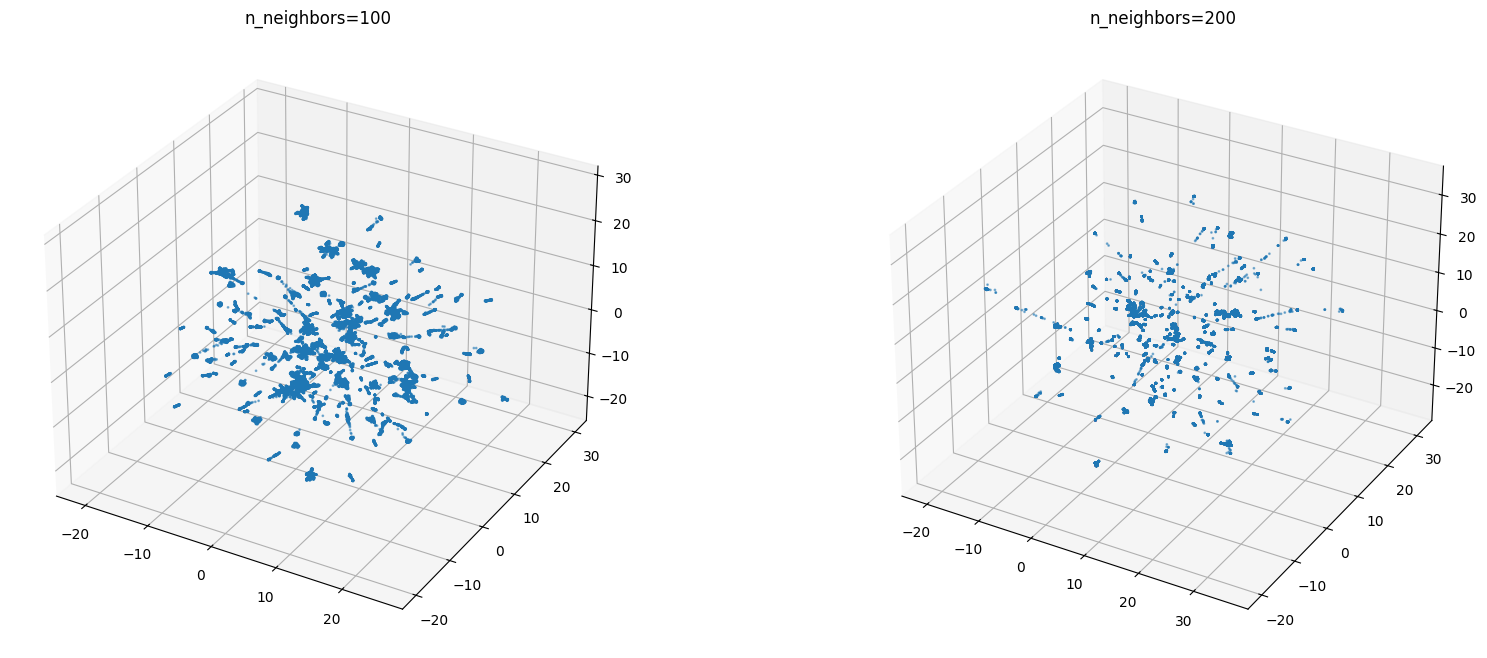

In [7]:
# testing top fit visuals 
reducer_100 = umap.UMAP(n_components=3, n_neighbors=100, min_dist=0.5, random_state=42)
reducer_200 = umap.UMAP(n_components=3, n_neighbors=200, min_dist=0.1, random_state=42)

embedding_100 = reducer_100.fit_transform(X_pca)
embedding_200 = reducer_200.fit_transform(X_pca)

# Plot both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d'})

ax1.scatter(embedding_100[:, 0], embedding_100[:, 1], embedding_100[:, 2], s=1, alpha=0.5)
ax1.set_title('n_neighbors=100')

ax2.scatter(embedding_200[:, 0], embedding_200[:, 1], embedding_200[:, 2], s=1, alpha=0.5)
ax2.set_title('n_neighbors=200')

plt.show()